In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

2024-02-17 16:17:15.711086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 16:17:15.711200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 16:17:15.859485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tukey = pd.read_pickle('/kaggle/input/tukey-prices/tukey_estimates.pkl')

In [3]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [4]:
starting_date_test = tukey.loc[:'2018-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2017-12-07 00:00:00')

In [5]:
train_price, test_price = tukey.loc[:'2018-01-02'], tukey.loc[starting_date_test:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [7]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [8]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1001, 15, 40)
(1001, 1, 40)
(254, 15, 40)
(254, 1, 40)


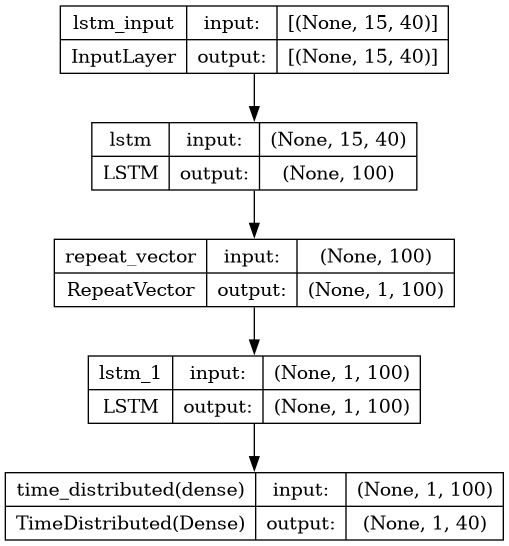

In [9]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')
plot_model(model=model_enc_dec, show_shapes=True)

In [10]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


I0000 00:00:1708186652.339137      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 5s 20ms/step - loss: 0.1214
Epoch 2/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0245
Epoch 3/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 4/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 5/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0065
Epoch 6/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0050
Epoch 7/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0041
Epoch 8/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0035
Epoch 9/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0032
Epoch 10/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 11/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0028
Epoch 12/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 13/50
32/32 [=============================

In [11]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [12]:
def inverse_transform(y_test, yhat):
 y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
 yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
 yhat_inverse = scaler.inverse_transform(yhat_reshaped)
 y_test_inverse = scaler.inverse_transform(y_test_reshaped)
 return yhat_inverse, y_test_inverse

In [23]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [24]:
yhat_inverse = pd.DataFrame(yhat_inverse, index=tukey.loc['2018-01-02':].index, columns=tukey.columns)
y_test_inverse = pd.DataFrame(y_test_inverse, index=tukey.loc['2018-01-02':].index, columns=tukey.columns)

In [25]:
yhat_inverse

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,GLE FP Equity,ITX SQ Equity,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,ABI BB Equity,DTE GY Equity
2018-01-02,146.544739,14.363941,106.626198,63.379074,30.048994,2.795629,73.665207,244.517441,5.315845,25.220835,...,43.005222,29.899969,186.750305,7.167646,145.916382,95.292953,15.362729,14.080292,93.689438,15.260801
2018-01-03,145.774429,14.283336,106.077103,63.098553,29.830673,2.776988,73.470009,242.291855,5.283226,25.119780,...,42.830349,29.804197,185.880463,7.143998,144.601883,94.749519,15.290907,14.064171,93.371506,15.206970
2018-01-04,145.170395,14.200527,105.665833,62.949543,29.690901,2.763010,73.383675,240.464600,5.253067,25.063841,...,42.797871,29.777407,185.255402,7.136328,143.521729,94.375404,15.252292,14.073582,93.216606,15.189502
2018-01-05,145.172653,14.152238,105.686829,63.052166,29.731066,2.763070,73.489838,240.144760,5.240025,25.107979,...,42.967438,29.878241,185.401077,7.158692,143.396317,94.455414,15.289625,14.126278,93.425095,15.238193
2018-01-08,146.380249,14.174944,106.691658,63.695686,30.166561,2.791559,74.070656,243.402695,5.266899,25.364538,...,43.610592,30.229456,186.963715,7.247025,145.287064,95.493217,15.482736,14.250970,94.302246,15.414636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,121.838036,12.236842,89.687866,54.184509,28.062044,2.146069,71.432091,207.245346,4.464374,21.557878,...,36.965820,30.322777,168.012497,6.294959,109.143082,87.234413,13.128241,13.963352,88.454208,14.041180
2018-12-24,121.496155,12.212965,89.223831,53.879803,27.855711,2.133356,71.316925,205.280243,4.445924,21.433607,...,36.690762,30.212902,167.027496,6.257027,107.564438,86.748497,13.023906,13.889503,88.149918,13.971754
2018-12-27,121.195564,12.186367,88.723015,53.557468,27.634325,2.118851,71.215324,203.002640,4.423297,21.297579,...,36.403305,30.102453,165.980850,6.214852,105.887505,86.230186,12.909861,13.818691,87.895020,13.904510
2018-12-28,120.776253,12.149549,88.210808,53.228954,27.401752,2.101737,71.100998,200.607590,4.396308,21.156322,...,36.120811,29.983232,164.917389,6.167682,104.153511,85.661118,12.791056,13.748095,87.626472,13.833441


In [26]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
 mse_ = tf.keras.losses.MeanSquaredError()
 mae_ = tf.keras.losses.MeanAbsoluteError()
 mape_ = tf.keras.losses.MeanAbsolutePercentageError()
 mae = mae_(y_test_inverse,yhat_inverse)
 print('mae:', mae)
 mse = mse_(y_test_inverse,yhat_inverse)
 print('mse:', mse)
 mape = mape_(y_test_inverse,yhat_inverse)
 print('mape:', mape)

In [27]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: tf.Tensor(6.0423036, shape=(), dtype=float32)
mse: tf.Tensor(122.187836, shape=(), dtype=float32)
mape: tf.Tensor(8.655122, shape=(), dtype=float32)


In [17]:
yhat_inverse.shape, y_test_inverse.shape

((254, 40), (254, 40))

In [36]:
yhat_inverse.iloc[:,0].name

'VOW3 GY Equity'

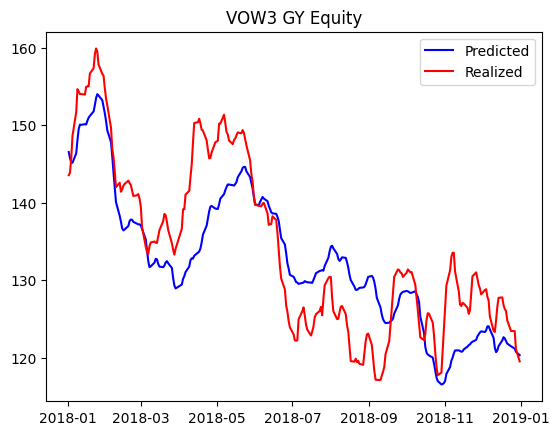

In [38]:
plt.plot(yhat_inverse.iloc[:,0], color='blue', label='Predicted')
plt.plot(y_test_inverse.iloc[:,0], color='red', label='Realized')
# plt.plot(tukey.loc['2018-01-02':,'VOW3 GY Equity'], color='green')
plt.legend()
plt.title(yhat_inverse.iloc[:,0].name)
plt.show()